<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import torch
import cv2
from google.colab.patches import cv2_imshow
import random
import numpy as np
import os
from IPython.display import clear_output,display
import time


from google.colab import files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import io
import kagglehub
import pandas as pd
from glob import glob


from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset

# !rm -rf /content/sample_data/*

# !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

# !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [90]:
metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [91]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)  # Depén de vosaltres
      image = self.transform(image)

      return image, label

In [92]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [93]:
TRAINING = 0.64
VALIDATION = 0.16
TESTING = 0.20
SIZE = 224

illnes_dictionary = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
img_files = img_files_1 + img_files_2

img_files = np.array(img_files)

#mitjana,desviacio = calcula_mitjana_desviacio(img_files)
#S'ha descobert amb aquesta funció que la mitjana = [194.57463374 139.13953272 145.36132088]
#I desviació= [35.92275236 38.90347617 43.33101831]
mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
])

imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

#Aquest illness_code s'utilitzarà com a label de la enfermetat

img_number = len(img_files)


X = metadates.drop('illness_code',axis= 1)
y = metadates['illness_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTING, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION/(TRAINING+VALIDATION), random_state=42, stratify=y_train)

#Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
#Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

#Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transform_training)
test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transform)
validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transform)


#prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
#prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
#prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

print(train_data.__getdist__())
train_data.__redistribute__([0.12,0.12,0.06,0.04,0.02,0.015])
print(train_data.__getdist__())
print(train_data.len)




0    4291
1     712
2     703
3     329
4     209
5      91
6      74
Name: count, dtype: int64
0    4291
1     819
2     819
3     409
4     272
5     135
6     101
Name: count, dtype: int64
6846


In [94]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [95]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [96]:
def tria_model(numero_model):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=None)

    for param in alexnetbinary.features.parameters():
            param.requires_grad = True

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    loss_fn = nn.BCEWithLogitsLoss()

    return alexnetbinary,loss_fn
  elif numero_model == 1:
    alexnetmulticlass = models.alexnet(weights=None)

    for param in alexnetmulticlass.features.parameters():
            param.requires_grad = True

    alexnetmulticlass.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    nn.Softmax(dim=1)
    )
    loss_fn = nn.CrossEntropyLoss()

    return alexnetmulticlass,loss_fn


In [97]:
BATCH_SIZE = 64
EPOCHS = 5

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [98]:
model,loss_fn = tria_model(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

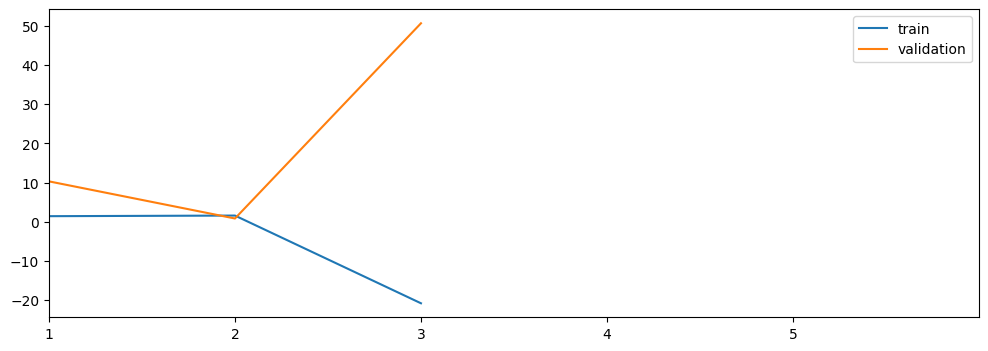

KeyboardInterrupt: 

In [99]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
import pylab as pl

t_loss = np.zeros(EPOCHS)
v_loss = np.zeros(EPOCHS)

pbar = tqdm(range(1, EPOCHS + 1))  # tdqm permet tenir text dinàmic

for epoch in pbar:

    train_loss = 0
    val_loss = 0


    for batch_num, (input_img, target) in enumerate(train_loader, 1):
        model.train()
        optimizer.zero_grad()

        target = target.to(device)
        target = torch.unsqueeze(target, 1)

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        # output = output.detach()
        # output = output.squeeze(1)
        # print(loss.requires_grad)  # Should be True
        # print(output.requires_grad)
        # print(output)
        # print(target)
        loss = loss_fn(output, target.float())
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for input_img, target in val_loader:
            input_img = input_img.to(device)

            target = target.to(device)
            target = torch.unsqueeze(target, 1)

            output = model(input_img)
            loss = loss_fn(output, target.float())
            val_loss += loss.item()

            # RESULTATS
    train_loss /= len(train_loader)
    t_loss[epoch - 1] = train_loss

    val_loss /= len(val_loader)
    v_loss[epoch - 1] = val_loss

    # VISUALITZACIO DINAMICA
    plt.figure(figsize=(12, 4))
    pl.plot(t_loss[:epoch], label="train")
    pl.plot(v_loss[:epoch], label="validation")
    pl.legend()
    pl.xlim(0, EPOCHS)
    pl.xticks(range(0, EPOCHS, 1), range(1, EPOCHS + 1, 1))

    clear_output(wait=True)
    display(pl.gcf())
    plt.close()

    pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

